# Linked Lorenz system simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def generate_a():
    try:
        omega = np.random.uniform(-np.pi/2, np.pi/2, size=N)

        g = nx.empty_graph()
        g.add_nodes_from(range(N)) #network with N nodes and no edges

        while any(g.degree(node) < D for node in g.nodes()):
            i = np.random.choice([node for node in g.nodes() if g.degree(node) < D])
            j = np.random.choice([node for node in g.nodes() if g.degree(node) < D and not g.has_edge(i, node) and node != i])

            p = (S**G)/(S**G + np.abs(omega[i]-omega[j])**G)

            if np.random.uniform(0,1) < p:
                g.add_edge(i,j)

        a = nx.to_numpy_array(g)
        return a, omega, g
    except:
        return generate_a()

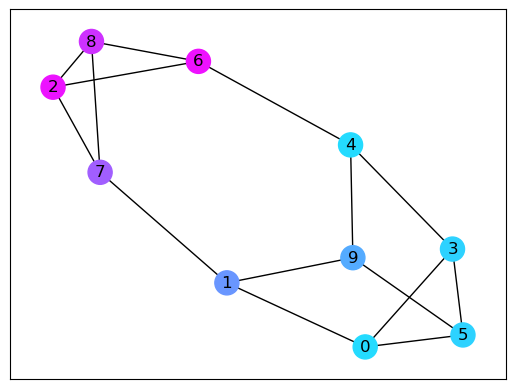

In [3]:
np.random.seed(14)

N = 10
D = 3
S = 0.8
G = 5
K = 0.5
        
a, omega, g = generate_a()
 

for node, value in zip(g.nodes(), omega):
    g.nodes[node]['omega'] = value

cmap = plt.colormaps['cool']

nx.draw_networkx(g, node_color=omega, cmap=cmap, vmin = -np.pi/2, vmax = np.pi/2)

# color map for natural frequencies
#sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = -np.pi/2, vmax = np.pi/2))
#sm.set_array(omega)
#plt.colorbar(sm)

plt.show()

In [4]:
def linked_lorenz(NE, z, a, n_timesteps, h = 0.02, rho = 28.0, beta = 2.667, sigma = 10.0, c = 0.09, method='RK45'):
    
    def linked_lorenz_diff(t, z):
        dz_dt = np.zeros(3*NE)
        for k in range(NE):
                # dx[k]/dt:
                for l in range(NE):
                    dz_dt[3*k] += a[k][l]*(z[3*l+1] - z[3*k+1])
                dz_dt[3*k] = -sigma*(z[3*k] -z[3*k+1] + c * dz_dt[3*k])    
                # dy[k]/dt:
                dz_dt[3*k+1] = rho*z[3*k] - z[3*k+1] - z[3*k+2]*z[3*k]
                # dz[k]/dt:
                dz_dt[3*k+2] = z[3*k]*z[3*k+1] - beta*z[3*k+2]
        return dz_dt
    

    t = np.arange(0, n_timesteps * h, h)
    
    if method == 'Euler':
        t = np.zeros((n_timesteps, 3*NE))
        t[0,:] = z
        for i in range(n_timesteps-1):
            t[i+1] = t[i] + h * linked_lorenz_diff(_, t[i])
        return t
    sol = solve_ivp(linked_lorenz_diff,  
                        t_span=(0.0, n_timesteps*h),
                        y0=z,
                        dense_output=True, vectorized=False,
                        method = method)
    
    
    return sol.sol(t).T

In [6]:
dimension = 3 # dimension of the dynamcal elements
timestep = 0.0075 # integration timestep
z = 2*(np.random.random(dimension*N)-0.5) #initial state
method = 'RK45'
data = linked_lorenz(N, z = z, a = a, n_timesteps = 80000, h = timestep,
                            rho = 28.0, beta = 2.667, sigma = 10.0, method=method)

data = data[5000:] #drop transient
#data = (data-data.min())/(data.max()-data.min()) #scaling
data.shape

(75000, 30)

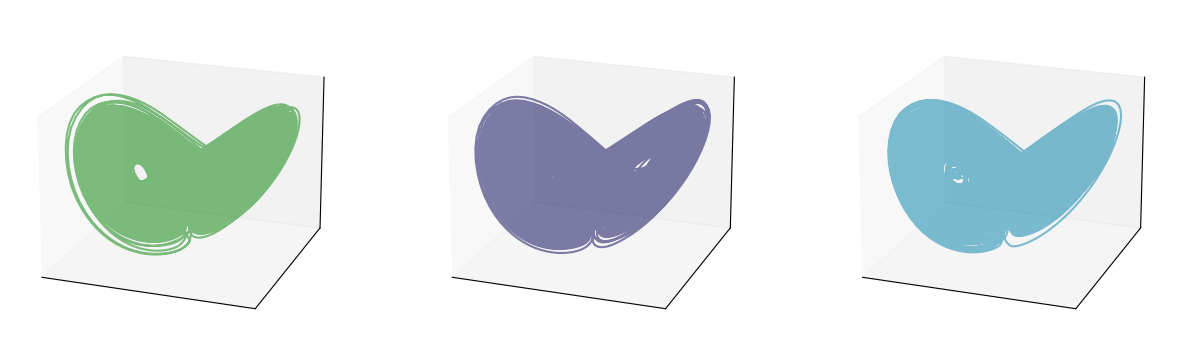

In [9]:
# First three "subsystems"

fig, axs = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': '3d'})

cmap = plt.get_cmap('ocean')
for i, ax in enumerate(axs):
    ax.plot(data[0:80000, 3*i], data[0:80000, 3*i+1], data[0:80000, 3*i+2], color=cmap(i / len(axs)), alpha=0.5)
    ax.view_init(elev=20, azim=290)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    
plt.savefig('coupled_lorenz3.pdf', format='pdf')

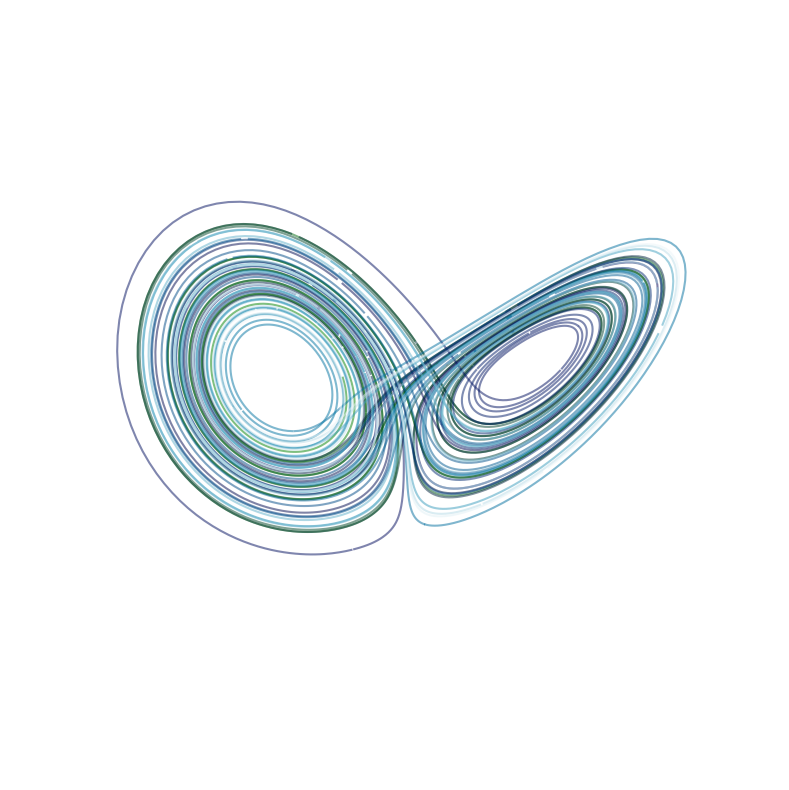

In [53]:
fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': '3d'})
s = 150
n = 15000
cmap = plt.get_cmap('ocean')
for i in range(0,n-s,s):
    ax.plot(data[i:i+s, 0], data[i:i+s, 1], data[i:i+s, 2], color=cmap(i/n), alpha=0.5)
#ax.autoscale()
ax.set_axis_off()
plt.savefig('lorenz_attractor.pdf', format='pdf')

In [41]:
!pwd

/scratch/work/tuomaaj3/reservoir_project/notebooks_dynamic_systems


In [90]:
train = [{"data":data[:20000], "dt":timestep, "adjacency_matrix":a, "N":N, "initLen":0}]
validation = [{"data":data[20000:25000], "dt":timestep, "adjacency_matrix":a, "N":N, "initLen":0}]
test = [{"data":data[25000:30000], "dt":timestep, "adjacency_matrix":a, "N":N, "initLen":0}]

In [91]:
np.save(f"../notebooks/simulation_data/linked_lorenz{N}/{method.lower()}/train.npy", train)
np.save(f"../notebooks/simulation_data/linked_lorenz{N}/{method.lower()}/validation.npy", validation)
np.save(f"../notebooks/simulation_data/linked_lorenz{N}/{method.lower()}/test.npy", test)

In [5]:
methods = ["Euler", "RK45"]
timestep = 0.0075
steps = int(600/timestep)
trsteps = int((steps*5)/8)
valsteps = int((steps*3)/16)
dimension = 3
z = 2*(np.random.random(dimension*N)-0.5) #initial state
for method in methods:
    data = linked_lorenz(N, z = z, a = a, n_timesteps = steps, h = timestep,
                            rho = 28.0, beta = 2.667, sigma = 10.0, method=method)

    #dmin = np.zeros(dimension*N)
    #dmax = np.zeros(dimension*N)
    #for s in range(dimension*N):
        #dmin[s] = data[:, s].min()
        #dmax[s] = data[:, s].max()
        #data[:,s] = (data[:,s] - dmin[s]) / (dmax[s] - dmin[s])
    
    train = [{"data":data[10000:trsteps], "dt":timestep, "adjacency_matrix":a, "N":N, "initLen":0}]
    validation = [{"data":data[trsteps:trsteps+valsteps], "dt":timestep, "adjacency_matrix":a, "N":N, "initLen":0}]
    test = [{"data":data[trsteps+valsteps:], "dt":timestep, "adjacency_matrix":a, "N":N, "initLen":0}]
    
    np.save(f"../notebooks/simulation_data/linked_lorenz{N}/{method.lower()}/train.npy", train)
    np.save(f"../notebooks/simulation_data/linked_lorenz{N}/{method.lower()}/validation.npy", validation)
    np.save(f"../notebooks/simulation_data/linked_lorenz{N}/{method.lower()}/test.npy", test)

11250